## Data Delivery and ETL

In [1]:
# import dependencies
import pandas as pd
from tabulate import tabulate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [2]:
# get movies dataset
movie_path = "Resources/movies.csv"
movie_df = pd.read_csv(movie_path)
print(' ')
print('Display movie_df:')
print(tabulate(movie_df[:5], headers='keys', tablefmt='fancy_grid'))
print(' ')
movie_df.head()

 
Display movie_df:
╒════╤═══════════╤════════════════════════════════════╤═════════════════════════════════════════════╕
│    │   movieId │ title                              │ genres                                      │
╞════╪═══════════╪════════════════════════════════════╪═════════════════════════════════════════════╡
│  0 │         1 │ Toy Story (1995)                   │ Adventure|Animation|Children|Comedy|Fantasy │
├────┼───────────┼────────────────────────────────────┼─────────────────────────────────────────────┤
│  1 │         2 │ Jumanji (1995)                     │ Adventure|Children|Fantasy                  │
├────┼───────────┼────────────────────────────────────┼─────────────────────────────────────────────┤
│  2 │         3 │ Grumpier Old Men (1995)            │ Comedy|Romance                              │
├────┼───────────┼────────────────────────────────────┼─────────────────────────────────────────────┤
│  3 │         4 │ Waiting to Exhale (1995)           │ Comedy

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# Splitting the title column
# Filtering out movies with a year greater than or equal to 2010
movie_df['year'] = movie_df['title'].str.extract(r'\((\d{4})\)')
movie_df['title'] = movie_df['title'].str.replace(r'\s*\(\d{4}\)', '')
movie_df['year'] = movie_df['year'].fillna(0)
movie_df['year'] = movie_df['year'].astype('int')
movie_df = movie_df[movie_df['year']>=2010]
movie_df.head()

C:\Users\justi\AppData\Local\Temp\ipykernel_15908\3969095623.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  movie_df['title'] = movie_df['title'].str.replace(r'\s*\(\d{4}\)', '')


,movieId,title,genres,year
14156,73268,Daybreakers,Action|Drama|Horror|Thriller,2010
14161,73319,Leap Year,Comedy|Romance,2010
14162,73321,"Book of Eli, The",Action|Adventure|Drama,2010
14222,73744,If You Love (Jos rakastat),Drama|Musical|Romance,2010
14256,73929,Legion,Action|Fantasy|Horror|Thriller,2010


In [4]:
# get a ratings dataset grouped by 'movieId' with the average rating
rating_path = "Resources/ratings_filter.csv"
rating_df = pd.read_csv(rating_path)
# rating_df = rating_df[['movieId', 'rating']].groupby('movieId').mean()
# rating_df = rating_df.reset_index()
rating_df = rating_df[['movieId', 'rating']]
rating_df.head()
print(' ')
print('Display rating_df:')
print(tabulate(rating_df[:5], headers='keys', tablefmt='fancy_grid'))
print(' ')

 
Display rating_df:
╒════╤═══════════╤══════════╕
│    │   movieId │   rating │
╞════╪═══════════╪══════════╡
│  0 │         1 │  3.89371 │
├────┼───────────┼──────────┤
│  1 │         2 │  3.25153 │
├────┼───────────┼──────────┤
│  2 │         3 │  3.14203 │
├────┼───────────┼──────────┤
│  3 │         4 │  2.85355 │
├────┼───────────┼──────────┤
│  4 │         5 │  3.05843 │
╘════╧═══════════╧══════════╛
 


In [5]:
# merge the 'movie_df' and 'rating_df' DataFrames together based on the 'movieId' column
new_df = pd.merge(movie_df, rating_df, left_index=False, right_index=False, how='inner', on='movieId')
new_df = new_df.sort_values('movieId')
new_df = new_df.drop(columns=['year'])
new_df.tail()
print(' ')
print('Display new_df:')
print(tabulate(new_df[:5], headers='keys', tablefmt='fancy_grid'))
print(' ')

 
Display new_df:
╒════╤═══════════╤════════════════════════════╤════════════════════════════════╤══════════╕
│    │   movieId │ title                      │ genres                         │   rating │
╞════╪═══════════╪════════════════════════════╪════════════════════════════════╪══════════╡
│  0 │     73268 │ Daybreakers                │ Action|Drama|Horror|Thriller   │  3.22421 │
├────┼───────────┼────────────────────────────┼────────────────────────────────┼──────────┤
│  1 │     73319 │ Leap Year                  │ Comedy|Romance                 │  3.31296 │
├────┼───────────┼────────────────────────────┼────────────────────────────────┼──────────┤
│  2 │     73321 │ Book of Eli, The           │ Action|Adventure|Drama         │  3.45985 │
├────┼───────────┼────────────────────────────┼────────────────────────────────┼──────────┤
│  3 │     73744 │ If You Love (Jos rakastat) │ Drama|Musical|Romance          │  2.66667 │
├────┼───────────┼────────────────────────────┼───────────────

## Exploratory Data Analysis

In [6]:
# Which genres have the most movies?
genre_count = new_df['genres'].value_counts()
genre_count

Drama                                2977
Documentary                          2532
Comedy                               1832
(no genres listed)                   1393
Comedy|Drama                          877
                                     ... 
Action|Fantasy|Thriller|IMAX            1
Animation|Comedy|Romance|Sci-Fi         1
Action|Adventure|Mystery|Thriller       1
Fantasy|Sci-Fi|Thriller                 1
Animation|Fantasy|Romance               1
Name: genres, Length: 830, dtype: int64

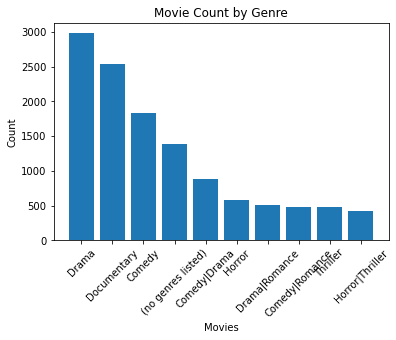

In [7]:
# Bar graph of top 10 genres by count
genre_df = pd.DataFrame(genre_count)
genre_df = genre_df.rename(columns={'genres':'count'}).sort_values('count',ascending=False).head(10)

plt.bar(genre_df.index, genre_df['count'])
plt.xlabel('Movies')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Movie Count by Genre')
plt.show()

In [8]:
# Which genres have the highest average rating?
genre_value_counts = new_df['genres'].value_counts()
selected_genres = genre_value_counts[genre_value_counts > 5].index
selected_df = new_df[new_df['genres'].isin(selected_genres)]
genre_ratings = selected_df.groupby('genres')['rating'].mean().sort_values(ascending=False).head(10)
genre_ratings

genres
Animation|Drama                3.635456
Documentary|War                3.625498
Animation|Comedy|Fantasy       3.594765
Adventure|Animation|Fantasy    3.583558
Documentary|Musical            3.571758
Children|Drama|Fantasy         3.566524
Drama|Fantasy|Mystery          3.543320
Comedy|Drama|Musical           3.468159
Adventure|Comedy|Drama         3.467543
Animation|Drama|Romance        3.464716
Name: rating, dtype: float64

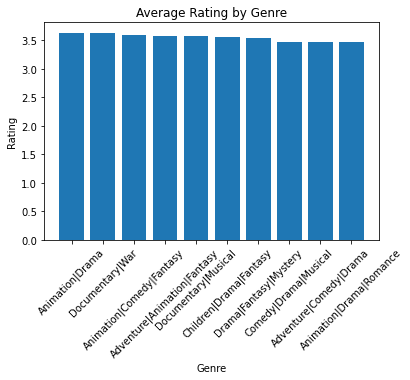

In [9]:
# Bar graph of top 10 genres by rating
plt.bar(genre_ratings.index,genre_ratings.values)
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.title('Average Rating by Genre')
plt.show()

## Movie Recommender Model


### Basic Knowledge of CountVectorizer : https://towardsdatascience.com/basics-of-countvectorizer-e26677900f9c

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Split the dataset into training and test sets
train_df, test_df = train_test_split(new_df, test_size=0.2, random_state=42)

# Extract features from genres using CountVectorizer on the training set
vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'))
X_train = vectorizer.fit_transform(train_df['genres'])

# Compute pairwise cosine similarity between genre vectors on the training set
cosine_sim_train = cosine_similarity(X_train)

# Extract features from genres using CountVectorizer on the test set
X_test = vectorizer.transform(test_df['genres'])

# Compute pairwise cosine similarity between genre vectors on the test set
cosine_sim_test = cosine_similarity(X_test)

In [11]:
# Create a function to recommend similar movies based on a given movie from the test set
def recommend_similar_movies(movie_title, n=10):
    # Get the index of the given movie in the test set
    movie_index = test_df[test_df['title'] == movie_title].index
    if len(movie_index) == 0:
        print(f"Movie '{movie_title}' not found in the dataset.")
        return None
    movie_index = movie_index[0]
    
    # Get the cosine similarity scores for the given movie from the test set
    similarity_scores = cosine_sim_test[movie_index]
    
    # Sort the movies based on similarity scores in descending order
    similar_movie_indices = np.argsort(similarity_scores)[::-1][:n]
    similarity_scores = similarity_scores[similar_movie_indices]
    
    # Get the titles, genres, and ratings of top similar movies from the test set
    similar_movies = test_df.loc[similar_movie_indices]['title']
    top_genres = test_df.loc[similar_movie_indices]['genres']
    top_ratings = test_df.loc[similar_movie_indices]['rating']
    
    # Sort the movies by rating in descending order
    sorted_indices = np.argsort(top_ratings)[::-1]
    similar_movies = similar_movies.iloc[sorted_indices]
    top_genres = top_genres.iloc[sorted_indices]
    top_ratings = top_ratings.iloc[sorted_indices]
    
    return similar_movies, similarity_scores, top_genres, top_ratings

In [12]:
# reset the index of test_df
test_df = test_df.reset_index()
test_df = test_df.drop(columns=['index'])
test_df.head()

,movieId,title,genres,rating
0,162964,Last Hijack,Animation|Documentary,3.500000
1,144222,Bros Before Hos,Comedy,2.611111
2,168156,Deserted Cities,(no genres listed),2.416667
3,163541,Guernica,Drama|Romance|War,3.000000
4,196399,When Jeff Tried to Save The World,Comedy|Drama,2.928571


## Movie Recommender Model Testing

In [13]:
# make a title list from test_df
test_title = test_df['title'].tolist()
print('----------------------------')
print(f'There are {len(test_title)} movies in the test dataset')

----------------------------
There are 4017 movies in the test dataset


In [14]:
# make a fuction to plot a bar chart showing the ratings of recommended movies.
def plot_similarity_scores(movies, scores):
    plt.figure(figsize=(10, 6))
    plt.bar(movies, scores, color='blue')
    plt.xlabel('Movies')
    plt.ylabel('Ratings')
    plt.xticks(rotation=90)
    plt.title('Scores of Top10 Movie')
    plt.show()


In [15]:
# That the user could enter a movie number within the range of 0-4016 
# and convert it into the corresponding movie name.
input_movie_order = int(input("choose and type a number (0 to 4016): "))
input_movie = test_title[input_movie_order]
print('----------------------------')
print(input_movie)

choose and type a number (0 to 4016): 152
----------------------------
Les Cowboys


In [16]:
def evaluate_recommendations_by_genres(input_movie):
    # Find the actual genres in the DataFrame based on the movie title
    actual_genres = new_df.loc[new_df['title'] == input_movie, 'genres'].tolist()
    if not actual_genres:
        print(f"Movie '{movie_title}' not found in the dataset.")
        return None
    actual_genres = actual_genres[0].split('|')

    # Get the recommended movies and their genres
    similar_movies, _, top_genres, _ = recommend_similar_movies(input_movie, n=10)

    # Get the genres of the recommended movies
    recommended_genres = top_genres.str.split('|')

    # Compute the accuracy score based on genres
    accuracy = sum(any(genre in actual_genres for genre in movie_genres) for movie_genres in recommended_genres) / len(recommended_genres)

    return accuracy

In [17]:
actual_genres = new_df.loc[new_df['title'] == 'Appetites']
type(actual_genres['genres'].tolist())

list

In [18]:
def show_results():
    similar_movies, similarity_scores, top_genres, top_ratings = recommend_similar_movies(input_movie, n=10)
    if similar_movies is not None:
        print(f"Recommended movies similar to '{input_movie}':")

        for movie, similarity, rating, genres, index in zip(similar_movies, similarity_scores, top_ratings, top_genres, range(1, 11)):
            print(f"Top{index} Movie: {movie}, Similarity: {round(similarity, 7)}, Genres: {genres}")
    score = evaluate_recommendations_by_genres(input_movie)
    
    print('----------------------------')
    print('----------------------------')
    print(f'accuracy score is {score}')
    plot_similarity_scores(similar_movies, top_ratings)

Recommended movies similar to 'Les Cowboys':
Top1 Movie: Vazante, Similarity: 1.0, Genres: Drama
Top2 Movie: Strawberry Summer, Similarity: 1.0, Genres: Drama
Top3 Movie: Butterfly Caught, Similarity: 1.0, Genres: Drama
Top4 Movie: Sing Street, Similarity: 1.0, Genres: Drama
Top5 Movie: October Baby, Similarity: 1.0, Genres: Drama
Top6 Movie: I Am Yours, Similarity: 1.0, Genres: Drama
Top7 Movie: Roxanne, Roxanne, Similarity: 1.0, Genres: Drama
Top8 Movie: You Will Be My Son (Tu seras mon fils), Similarity: 1.0, Genres: Drama
Top9 Movie: Beats, Similarity: 1.0, Genres: Drama
Top10 Movie: 3/4, Similarity: 1.0, Genres: Drama
----------------------------
----------------------------
accuracy score is 1.0


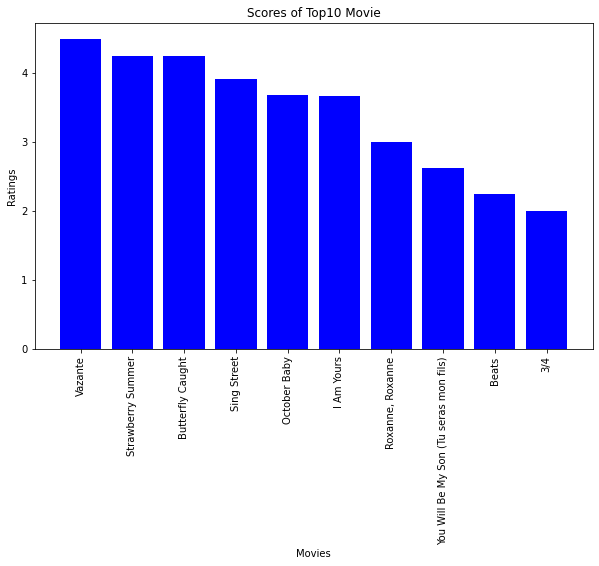

In [19]:
show_results()

## Rating Predictor Model

In [20]:
# Preprocessing: using vectorizer to transform text into numbered matrix
genre_feats=vectorizer.transform(new_df['genres'])

# Splitting the data into training and testing sets
X=genre_feats.todense()
X=np.asarray(X)
y=new_df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initiate Random Forest Regressor model
rf=RandomForestRegressor()

# Fit on data
rf.fit(X_train,  y_train)

RandomForestRegressor()

In [21]:
# Predicting on the test set
y_pred = rf.predict(X_test)


# Evaluate Model performance
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
r2_score = rf.score(X_train, y_train)
print("R-squared Score:", r2_score)



Mean Squared Error: 0.5674207441835547
R-squared Score: 0.12109456947949171


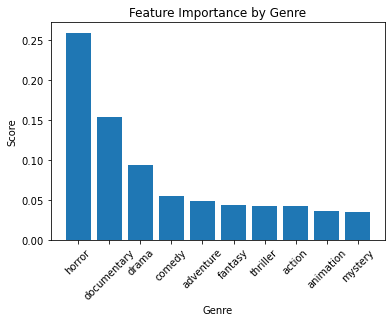

In [22]:
# Feature importance
sorted(list(zip(rf.feature_importances_, vectorizer.get_feature_names_out())))
ft_df = pd.DataFrame(rf.feature_importances_, vectorizer.get_feature_names_out())
ft_df = ft_df.rename(columns={0:'Feature Importance'})
ft_df = ft_df.sort_values('Feature Importance', ascending = False).head(10)

plt.bar(ft_df.index, ft_df['Feature Importance'])
plt.xlabel('Genre')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.title('Feature Importance by Genre')
plt.show()

## Rating Model Testing

In [23]:
def predict_ratings():
    print('example input: Action|Comedy|Drama')
    user_genre_input = input('choose a genre, use "|" between genres if choosing multiple: ')
    user_input_vector=vectorizer.transform([user_genre_input])
    user_input_vector=user_input_vector.todense()
    user_input = np.asarray(user_input_vector)
    print('----------------------------')
    print(f'the predicted rating for your genre: {rf.predict(user_input)}')

In [24]:
predict_ratings()

example input: Action|Comedy|Drama
choose a genre, use "|" between genres if choosing multiple: Action|Comedy|Drama
----------------------------
the predicted rating for your genre: [2.96790753]
